In [1]:
# Two-dimension, with K^, two bottle test
# Simulation for Matsuda et al., 2017 Nature Neurosci.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statistics as st
import random
from scipy import stats
from matplotlib import gridspec


In [3]:
N_i = 1200# Number of iterations in a set
N_exp = 5# Number of sets of iterations; same as simulation 1

# Parameters ########################

alp_Kh = 0.3# Learning rate (alpha) of K^
alp_Q = 0.03# Learning rate (alpha) of Q
beta = 10# Inverse temperature
tau = [7000, 7000]# Attenuation rate (Water and sodium)

mouth = [0.2, 0.4]# Volume of an intake
H_ast = 50
##################################
fs = 18# Font size
rd = 0.1# Density of error region color



In [4]:
class Gen:
    def __init__(self, init_W, init_Na):
        self.N = N_i
        self.a = np.zeros(self.N)# 0 ,1 or 2
        self.D = np.zeros(self.N+1)# D(Ht)
        self.D_est = np.zeros(self.N+1)# D(Ht+1)
        self.H = np.zeros((2, self.N+1))# Internal states (water, sodium)
        self.H[0] = init_W
        self.H[1] = init_Na
        self.H_ast = H_ast# The ideal point
        self.P = np.zeros((3,self.N))# P(intake)
        
        self.K = np.zeros((2, self.N))# an intake amount
        self.Kh = np.zeros((2, 3, self.N+1))# K^...oral sense of intake
        self.Q = np.zeros((3, self.N+1))# Action values
        
        self.R = np.zeros(self.N)# Reward of each action
        self.m = 3# A constant of the homeostatic space
        self.n = 4# The other constant of the homeostatic space
        
        self.alp_Kh = alp_Kh# Learning rate of K^
        self.alp_Q = alp_Q# Learning rate of Q-value
        self.beta = beta# Inverse temperature
        self.tau = tau
        self.mouth = mouth# Volume of an intake
        
        
    def softmax(self, t):
        self.t = t
        sigma = np.sum(np.exp(self.Q[:, self.t]*self.beta))
        vals = []
        for i in range(3):
            softmax = np.exp(self.Q[i, self.t]*self.beta)/sigma
            vals.append(softmax)
        
        # 0...Do nothing; 1...Water intake; 2...Saltwater intake
        if i == 0:
            self.P[0][self.t] = softmax
        elif i == 1:
            self.P[1][self.t] = softmax
        elif i == 2:
            self.P[2][self.t] = softmax
            
        dice = random.random()
        if dice <= vals[0]:
            self.a[self.t] = 0
        elif vals[0] < dice <= vals[0]+vals[1]:
            self.a[self.t] = 1
        else:
            self.a[self.t] = 2
        
        
    def get_Kh(self, t):
        self.t = t
        if self.a[self.t] == 0:# Do nothing
            self.K[0][self.t] = 0
            self.K[1][self.t] = 0
            self.Kh[0][0][self.t+1] = self.Kh[0][0][self.t]
            self.Kh[0][1][self.t+1] = self.Kh[0][1][self.t]
            self.Kh[0][2][self.t+1] = self.Kh[0][2][self.t]
            self.Kh[1][0][self.t+1] = self.Kh[1][0][self.t]
            self.Kh[1][1][self.t+1] = self.Kh[1][1][self.t]
            self.Kh[1][2][self.t+1] = self.Kh[1][2][self.t]
        
        elif self.a[self.t] == 1:# Water intake
            self.K[0][self.t] = self.mouth[0]
            self.K[1][self.t] = 0
            self.Kh[0][0][self.t+1] = self.Kh[0][0][self.t]
            self.Kh[0][1][self.t+1] = (1 - self.alp_Kh)*self.Kh[0][1][self.t] + self.alp_Kh*self.mouth[0]
            self.Kh[0][2][self.t+1] = self.Kh[0][2][self.t]
            self.Kh[1][0][self.t+1] = self.Kh[1][0][self.t]
            self.Kh[1][1][self.t+1] = self.Kh[1][1][self.t]
            self.Kh[1][2][self.t+1] = self.Kh[1][2][self.t]
            
        elif self.a[self.t] == 2:# Saltwater intake
            self.K[0][self.t] = self.mouth[0]
            self.K[1][self.t] = self.mouth[1]
            self.Kh[0][0][self.t+1] = self.Kh[0][0][self.t]
            self.Kh[0][1][self.t+1] = self.Kh[0][1][self.t]
            self.Kh[0][2][self.t+1] = (1 - self.alp_Kh)*self.Kh[0][2][self.t] + self.alp_Kh*self.mouth[0]
            self.Kh[1][0][self.t+1] = self.Kh[1][0][self.t]
            self.Kh[1][1][self.t+1] = self.Kh[1][1][self.t]
            self.Kh[1][2][self.t+1] = (1 - self.alp_Kh)*self.Kh[1][2][self.t] + self.alp_Kh*self.mouth[1]
            
        
    def get_D(self, t):
        self.t = t
        self.D[self.t] =  (abs(self.H_ast - self.H[0][self.t])**self.n
                           + abs(self.H_ast - self.H[1][self.t])**self.n)**(1/self.m)
        if self.a[self.t] == 1:
            self.D_est[self.t] = (abs(self.H_ast - (1 - 1/self.tau[0]) * self.H[0][self.t] - self.Kh[0][1][self.t+1])**self.n
                                 + abs(self.H_ast - (1 - 1/self.tau[1]) * self.H[1][self.t] - self.Kh[1][1][self.t+1])**self.n)**(1/self.m)
        elif self.a[self.t] == 2:
            self.D_est[self.t] = (abs(self.H_ast - (1 - 1/self.tau[0]) * self.H[0][self.t] - self.Kh[0][2][self.t+1])**self.n
                                 + abs(self.H_ast - (1 - 1/self.tau[1]) * self.H[1][self.t] - self.Kh[1][2][self.t+1])**self.n)**(1/self.m)
        else:
            self.D_est[self.t] = (abs(self.H_ast - (1 - 1/self.tau[0]) * self.H[0][self.t] - self.Kh[0][0][self.t+1])**self.n
                                 + abs(self.H_ast - (1 - 1/self.tau[1]) * self.H[1][self.t] - self.Kh[1][0][self.t+1])**self.n)**(1/self.m)
        

    def get_R(self, t):
        self.t = t
        self.R[self.t] = self.D[self.t] - self.D_est[self.t]
        
    
    def get_H(self, t):
        self.t = t
        self.H[0][self.t+1] = (1 - 1/self.tau[0]) * self.H[0][self.t] + self.K[0][self.t]
        self.H[1][self.t+1] = (1 - 1/self.tau[1]) * self.H[1][self.t] + self.K[1][self.t]
        
        
    def get_Q(self, t):
        self.t = t
        if self.a[self.t] == 0:
            self.Q[0][self.t+1] = self.Q[0][self.t] + self.alp_Q*(self.R[self.t] - self.Q[0][self.t])
            self.Q[1][self.t+1] = self.Q[1][self.t]
            self.Q[2][self.t+1] = self.Q[2][self.t]
        
        elif self.a[self.t] == 1:
            self.Q[0][self.t+1] = self.Q[0][self.t]
            self.Q[1][self.t+1] = self.Q[1][self.t] + self.alp_Q*(self.R[self.t] - self.Q[1][self.t])
            self.Q[2][self.t+1] = self.Q[2][self.t]
            
        elif self.a[self.t] == 2:
            self.Q[0][self.t+1] = self.Q[0][self.t]
            self.Q[1][self.t+1] = self.Q[1][self.t]
            self.Q[2][self.t+1] = self.Q[2][self.t] + self.alp_Q*(self.R[self.t] - self.Q[2][self.t])

        
        
        

        

In [5]:
# Control group (Cell 1)
# -----------------
num_l = list(range(N_i+1))
N_exp_l = list(range(N_exp))

a_H0 = np.zeros(N_exp * (N_i+1))
a_H1 = np.zeros(N_exp * (N_i+1))

a_Q0 = np.zeros(N_exp * (N_i+1))
a_Q1 = np.zeros(N_exp * (N_i+1))
a_Q2 = np.zeros(N_exp * (N_i+1))

a_P0 = np.zeros(N_exp * (N_i+1))
a_P1 = np.zeros(N_exp * (N_i+1))
a_P2 = np.zeros(N_exp * (N_i+1))

a_a = np.zeros(N_exp * (N_i+1))
a_R = np.zeros(N_exp * (N_i+1))

# a_Kh0 = np.zeros(N_exp * (N_i+1))
# a_Kh1 = np.zeros(N_exp * (N_i+1))

class_l = []# List for classes

#To make list of Classes
for i in range(N_exp):
    class_l.append(None)

    
#main
for j in range(N_exp):
    class_l[j] = Gen(init_W=H_ast, init_Na=H_ast)
    for i in range(N_i):
        class_l[j].softmax(i)
        class_l[j].get_Kh(i)
        class_l[j].get_D(i)
        class_l[j].get_R(i)
        class_l[j].get_H(i)
        class_l[j].get_Q(i)

        
    #長さが1つ小さい変数は前詰めで、最後の変数を0のままにする。
    
    a_H0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].H[0]
    a_H1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].H[1]
    
    a_Q0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Q[0]
    a_Q1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Q[1]
    a_Q2[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Q[2]
    
    a_P0[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].P[0], np.nan)
    a_P1[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].P[1], np.nan)
    a_P2[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].P[2], np.nan)
    
    a_a[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].a, np.nan)
    a_R[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(class_l[j].R, np.nan)
    
    # a_Kh0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[0][1]
    # a_Kh1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[1][]


df = pd.DataFrame(data=list(range((N_i+1))) * N_exp, columns=['trial'])

df['H0'] = a_H0
df['H1'] = a_H1

df['Q0'] = a_Q0
df['Q1'] = a_Q1
df['Q2'] = a_Q2

df['P0'] = a_P0
df['P1'] = a_P1
df['P2'] = a_P2

df['A'] = a_a

df['R'] = a_R

# df['Kh0'] = a_Kh0
# df['Kh1'] = a_Kh1        



/Users/yukiuchida/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/yukiuchida/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


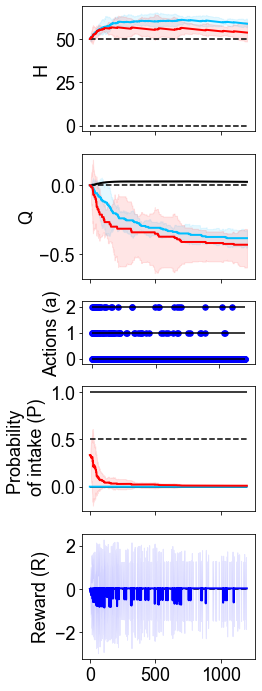

In [6]:
# Control group (Cell 2)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 18
fig = plt.figure(figsize=(4,12))

spec = gridspec.GridSpec(ncols=1, nrows=5, height_ratios=[2,2,1,2,2])

ax_l = []
ax_l.append(fig.add_subplot(spec[0]))
ax_l.append(fig.add_subplot(spec[1]))
ax_l.append(fig.add_subplot(spec[2]))
ax_l.append(fig.add_subplot(spec[3]))
ax_l.append(fig.add_subplot(spec[4]))


CL = 0.95# Confidencial Level for Figures
Df = N_exp-1# degree of freedom for Figures

mean = [] #mean at t
STD = []
#SE = []# Standard Error for Figures
CI = np.zeros((8, N_i+1, 2)) #confidence intervals at t


for j, h in zip(['H0','H1','Q0','Q1','Q2','P1','P2','R'], list(range(8))):
    for i in range(N_i+1):
        mean.append(sum(df.loc[df['trial']==i][j])/N_exp)
        STD.append(st.stdev(df.loc[df['trial']==i][j]))
        CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = 2*STD[-1])[0]
        CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = 2*STD[-1])[1]
        
         
length_l, length_s = N_i+1, N_i


ax_l[0].hlines(50, 0, N_i, linestyle="dashed")
ax_l[0].hlines(0, 0, N_i, linestyle="dashed")
ax_l[0].plot(df['H0'][:length_l], linewidth=2, color='#00BFFF')
ax_l[0].plot(df['H1'][:length_l], linewidth=2, color='red')
ax_l[0].fill_between(df.index[:length_l], CI[0, :, 0], CI[0, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
ax_l[0].fill_between(df.index[:length_l], CI[1, :, 0], CI[1, :, 1], color='red', alpha=rd) #confidence interval curves.
ax_l[0].set_ylabel('H', fontsize=fs, fontname='Arial')
ax_l[0].tick_params(labelbottom=False)


ax_l[1].hlines(0, 0, N_i, linestyle="dashed")
ax_l[1].plot(df['Q0'][:length_l], linewidth=2, color='black')
ax_l[1].fill_between(df.index[:length_l], CI[2, :, 0], CI[2, :, 1], color='black', alpha=rd) #confidence interval curves.
ax_l[1].plot(df['Q1'][:length_l], linewidth=2, color='#00BFFF')
ax_l[1].fill_between(df.index[:length_l], CI[3, :, 0], CI[3, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
ax_l[1].plot(df['Q2'][:length_l], linewidth=2, color='red')
ax_l[1].fill_between(df.index[:length_l], CI[4, :, 0], CI[4, :, 1], color='red', alpha=rd) #confidence interval curves.
ax_l[1].set_ylabel('Q' , fontsize=fs, fontname='Arial')
ax_l[1].tick_params(labelbottom=False)


ax_l[2].hlines(0, 0, N_i)
ax_l[2].hlines(1, 0, N_i)
ax_l[2].hlines(2, 0, N_i)
ax_l[2].scatter(list(range(length_s)), df['A'][:length_s], s=30, c='blue')
ax_l[2].set_ylabel('Actions (a)' , fontsize=fs, fontname='Arial')
ax_l[2].set_yticks([0,1,2])
ax_l[2].tick_params(labelbottom=False)


ax_l[3].hlines(0, 0, N_i)
ax_l[3].hlines(0.5, 0, N_i,  linestyle="dashed")
ax_l[3].hlines(1, 0, N_i)
ax_l[3].plot(df['P1'][:length_s], linewidth=2, color='#00BFFF')
ax_l[3].plot(df['P2'][:length_s], linewidth=2, color='red')
ax_l[3].fill_between(df.index[:length_s], CI[5, :, 0][:length_s], CI[5, :, 1][:length_s], color='#00BFFF', alpha=rd) #confidence interval curves.
ax_l[3].fill_between(df.index[:length_s], CI[6, :, 0][:length_s], CI[6, :, 1][:length_s], color='red', alpha=rd) #confidence interval curves.
ax_l[3].set_ylabel('Probability \n of intake (P)' , fontsize=fs, fontname='Arial')
ax_l[3].tick_params(labelbottom=False)


ax_l[4].hlines(0, 0, N_i, linestyle="dashed")
ax_l[4].plot(df['R'][:length_s], linewidth=2, color='blue')
ax_l[4].fill_between(df.index[:length_s], CI[7, :, 0][:length_s], CI[7, :, 1][:length_s], color='blue', alpha=rd) #confidence interval curves.
ax_l[4].set_ylabel('Reward (R)' , fontsize=fs, fontname='Arial')

fig.subplots_adjust(left=0.3)
fig.savefig("Fig3I.png")




In [7]:
# W/Na-dep group (Cell 1)
# -----------------
wna_num_l = list(range(N_i+1))
wna_N_exp_l = list(range(N_exp))

wna_a_H0 = np.zeros(N_exp * (N_i+1))
wna_a_H1 = np.zeros(N_exp * (N_i+1))

wna_a_Q0 = np.zeros(N_exp * (N_i+1))
wna_a_Q1 = np.zeros(N_exp * (N_i+1))
wna_a_Q2 = np.zeros(N_exp * (N_i+1))

wna_a_P0 = np.zeros(N_exp * (N_i+1))
wna_a_P1 = np.zeros(N_exp * (N_i+1))
wna_a_P2 = np.zeros(N_exp * (N_i+1))

wna_a_a = np.zeros(N_exp * (N_i+1))
wna_a_R = np.zeros(N_exp * (N_i+1))

# wna_a_Kh0 = np.zeros(N_exp * (N_i+1))
# wna_a_Kh1 = np.zeros(N_exp * (N_i+1))

wna_class_l = []# List for classes

#To make list of Classes
for i in range(N_exp):
    wna_class_l.append(None)

    
#main
for j in range(N_exp):
    wna_class_l[j] = Gen(init_W=0, init_Na=0)
    for i in range(N_i):
        wna_class_l[j].softmax(i)
        wna_class_l[j].get_Kh(i)
        wna_class_l[j].get_D(i)
        wna_class_l[j].get_R(i)
        wna_class_l[j].get_H(i)
        wna_class_l[j].get_Q(i)

        

    
    wna_a_H0[(N_i+1)*j : (N_i+1)*(j+1)] = wna_class_l[j].H[0]
    wna_a_H1[(N_i+1)*j : (N_i+1)*(j+1)] = wna_class_l[j].H[1]
    
    wna_a_Q0[(N_i+1)*j : (N_i+1)*(j+1)] = wna_class_l[j].Q[0]
    wna_a_Q1[(N_i+1)*j : (N_i+1)*(j+1)] = wna_class_l[j].Q[1]
    wna_a_Q2[(N_i+1)*j : (N_i+1)*(j+1)] = wna_class_l[j].Q[2]
    
    wna_a_P0[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(wna_class_l[j].P[0], np.nan)
    wna_a_P1[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(wna_class_l[j].P[1], np.nan)
    wna_a_P2[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(wna_class_l[j].P[2], np.nan)
    
    wna_a_a[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(wna_class_l[j].a, np.nan)
    wna_a_R[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(wna_class_l[j].R, np.nan)
    
    # a_Kh0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[0][1]
    # a_Kh1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[1][]


wna_df = pd.DataFrame(data=list(range((N_i+1))) * N_exp, columns=['trial'])

wna_df['H0'] = wna_a_H0
wna_df['H1'] = wna_a_H1

wna_df['Q0'] = wna_a_Q0
wna_df['Q1'] = wna_a_Q1
wna_df['Q2'] = wna_a_Q2

wna_df['P0'] = wna_a_P0
wna_df['P1'] = wna_a_P1
wna_df['P2'] = wna_a_P2

wna_df['A'] = wna_a_a

wna_df['R'] = wna_a_R

# df['Kh0'] = a_Kh0
# df['Kh1'] = a_Kh1        



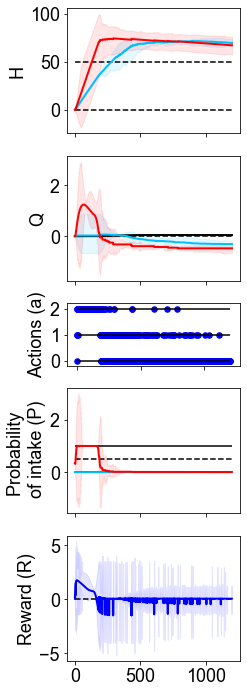

In [8]:
# W/Na-dep group (Cell 2)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 18
wna_fig = plt.figure(figsize=(4,12))

wna_spec = gridspec.GridSpec(ncols=1, nrows=5, height_ratios=[2,2,1,2,2])

wna_ax_l = []
wna_ax_l.append(wna_fig.add_subplot(wna_spec[0]))
wna_ax_l.append(wna_fig.add_subplot(wna_spec[1]))
wna_ax_l.append(wna_fig.add_subplot(wna_spec[2]))
wna_ax_l.append(wna_fig.add_subplot(wna_spec[3]))
wna_ax_l.append(wna_fig.add_subplot(wna_spec[4]))


CL = 0.95# Confidencial Level for Figures
Df = N_exp-1# degree of freedom for Figures

wna_mean = [] #mean at t
wna_STD = []
#SE = []# Standard Error for Figures
wna_CI = np.zeros((8, N_i+1, 2)) #confidence intervals at t


for j, h in zip(['H0','H1','Q0','Q1','Q2','P1','P2','R'], list(range(8))):
    for i in range(N_i+1):
        wna_mean.append(sum(wna_df.loc[wna_df['trial']==i][j])/N_exp)
        wna_STD.append(st.stdev(wna_df.loc[wna_df['trial']==i][j]))
        wna_CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = wna_mean[-1], scale = 2*wna_STD[-1])[0]
        wna_CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = wna_mean[-1], scale = 2*wna_STD[-1])[1]
        
         
length_l, length_s = N_i+1, N_i


wna_ax_l[0].hlines(50, 0, N_i, linestyle="dashed")
wna_ax_l[0].hlines(0, 0, N_i, linestyle="dashed")
wna_ax_l[0].plot(wna_df['H0'][:length_l], linewidth=2, color='#00BFFF')
wna_ax_l[0].plot(wna_df['H1'][:length_l], linewidth=2, color='red')
wna_ax_l[0].fill_between(wna_df.index[:length_l], wna_CI[0, :, 0], wna_CI[0, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
wna_ax_l[0].fill_between(wna_df.index[:length_l], wna_CI[1, :, 0], wna_CI[1, :, 1], color='red', alpha=rd) #confidence interval curves.
wna_ax_l[0].set_ylabel('H', fontsize=fs, fontname='Arial')
wna_ax_l[0].tick_params(labelbottom=False)


wna_ax_l[1].hlines(0, 0, N_i, linestyle="dashed")
wna_ax_l[1].plot(wna_df['Q0'][:length_l], linewidth=2, color='black')
wna_ax_l[1].fill_between(wna_df.index[:length_l], wna_CI[2, :, 0], wna_CI[2, :, 1], color='black', alpha=rd) #confidence interval curves.
wna_ax_l[1].plot(wna_df['Q1'][:length_l], linewidth=2, color='#00BFFF')
wna_ax_l[1].fill_between(wna_df.index[:length_l], wna_CI[3, :, 0], wna_CI[3, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
wna_ax_l[1].plot(wna_df['Q2'][:length_l], linewidth=2, color='red')
wna_ax_l[1].fill_between(wna_df.index[:length_l], wna_CI[4, :, 0], wna_CI[4, :, 1], color='red', alpha=rd) #confidence interval curves.
wna_ax_l[1].set_ylabel('Q' , fontsize=fs, fontname='Arial')
wna_ax_l[1].tick_params(labelbottom=False)


wna_ax_l[2].hlines(0, 0, N_i)
wna_ax_l[2].hlines(1, 0, N_i)
wna_ax_l[2].hlines(2, 0, N_i)
wna_ax_l[2].scatter(list(range(length_s)), wna_df['A'][:length_s], s=30, c='blue')
wna_ax_l[2].set_ylabel('Actions (a)' , fontsize=fs, fontname='Arial')
wna_ax_l[2].set_yticks([0,1,2])
wna_ax_l[2].tick_params(labelbottom=False)


wna_ax_l[3].hlines(0, 0, N_i)
wna_ax_l[3].hlines(0.5, 0, N_i,  linestyle="dashed")
wna_ax_l[3].hlines(1, 0, N_i)
wna_ax_l[3].plot(wna_df['P1'][:length_s], linewidth=2, color='#00BFFF')
wna_ax_l[3].plot(wna_df['P2'][:length_s], linewidth=2, color='red')
wna_ax_l[3].fill_between(wna_df.index[:length_s], wna_CI[5, :, 0][:length_s], wna_CI[5, :, 1][:length_s], color='#00BFFF', alpha=rd) #confidence interval curves.
wna_ax_l[3].fill_between(wna_df.index[:length_s], wna_CI[6, :, 0][:length_s], wna_CI[6, :, 1][:length_s], color='red', alpha=rd) #confidence interval curves.
wna_ax_l[3].set_ylabel('Probability \n of intake (P)' , fontsize=fs, fontname='Arial')
wna_ax_l[3].tick_params(labelbottom=False)


wna_ax_l[4].hlines(0, 0, N_i, linestyle="dashed")
wna_ax_l[4].plot(wna_df['R'][:length_s], linewidth=2, color='blue')
wna_ax_l[4].fill_between(wna_df.index[:length_s], wna_CI[7, :, 0][:length_s], wna_CI[7, :, 1][:length_s], color='blue', alpha=rd) #confidence interval curves.
wna_ax_l[4].set_ylabel('Reward (R)' , fontsize=fs, fontname='Arial')

wna_fig.subplots_adjust(left=0.3)
wna_fig.savefig("Fig3F.png")



In [9]:
# Na-deficient group (Cell 1)
# -----------------
na_num_l = list(range(N_i+1))
na_N_exp_l = list(range(N_exp))

na_a_H0 = np.zeros(N_exp * (N_i+1))
na_a_H1 = np.zeros(N_exp * (N_i+1))

na_a_Q0 = np.zeros(N_exp * (N_i+1))
na_a_Q1 = np.zeros(N_exp * (N_i+1))
na_a_Q2 = np.zeros(N_exp * (N_i+1))

na_a_P0 = np.zeros(N_exp * (N_i+1))
na_a_P1 = np.zeros(N_exp * (N_i+1))
na_a_P2 = np.zeros(N_exp * (N_i+1))

na_a_a = np.zeros(N_exp * (N_i+1))
na_a_R = np.zeros(N_exp * (N_i+1))

# a_Kh0 = np.zeros(N_exp * (N_i+1))
# a_Kh1 = np.zeros(N_exp * (N_i+1))

na_class_l = []# List for classes

#To make list of Classes
for i in range(N_exp):
    na_class_l.append(None)

    
#main
for j in range(N_exp):
    na_class_l[j] = Gen(init_W=H_ast, init_Na=0)
    for i in range(N_i):
        na_class_l[j].softmax(i)
        na_class_l[j].get_Kh(i)
        na_class_l[j].get_D(i)
        na_class_l[j].get_R(i)
        na_class_l[j].get_H(i)
        na_class_l[j].get_Q(i)


    
    na_a_H0[(N_i+1)*j : (N_i+1)*(j+1)] = na_class_l[j].H[0]
    na_a_H1[(N_i+1)*j : (N_i+1)*(j+1)] = na_class_l[j].H[1]
    
    na_a_Q0[(N_i+1)*j : (N_i+1)*(j+1)] = na_class_l[j].Q[0]
    na_a_Q1[(N_i+1)*j : (N_i+1)*(j+1)] = na_class_l[j].Q[1]
    na_a_Q2[(N_i+1)*j : (N_i+1)*(j+1)] = na_class_l[j].Q[2]
    
    na_a_P0[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(na_class_l[j].P[0], np.nan)
    na_a_P1[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(na_class_l[j].P[1], np.nan)
    na_a_P2[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(na_class_l[j].P[2], np.nan)
    
    na_a_a[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(na_class_l[j].a, np.nan)
    na_a_R[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(na_class_l[j].R, np.nan)
    
    # a_Kh0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[0][1]
    # a_Kh1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[1][]


na_df = pd.DataFrame(data=list(range((N_i+1))) * N_exp, columns=['trial'])

na_df['H0'] = na_a_H0
na_df['H1'] = na_a_H1

na_df['Q0'] = na_a_Q0
na_df['Q1'] = na_a_Q1
na_df['Q2'] =  na_a_Q2

na_df['P0'] = na_a_P0
na_df['P1'] = na_a_P1
na_df['P2'] = na_a_P2

na_df['A'] = na_a_a

na_df['R'] = na_a_R

# df['Kh0'] = a_Kh0
# df['Kh1'] = a_Kh1        



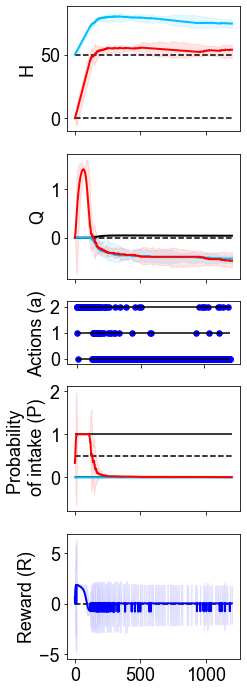

In [10]:
# Control group (Cell 2)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 18
na_fig = plt.figure(figsize=(4, 12))

na_spec = gridspec.GridSpec(ncols=1, nrows=5, height_ratios=[2,2,1,2,2])

na_ax_l = []
na_ax_l.append(na_fig.add_subplot(na_spec[0]))
na_ax_l.append(na_fig.add_subplot(na_spec[1]))
na_ax_l.append(na_fig.add_subplot(na_spec[2]))
na_ax_l.append(na_fig.add_subplot(na_spec[3]))
na_ax_l.append(na_fig.add_subplot(na_spec[4]))


CL = 0.95# Confidencial Level for Figures
Df = N_exp-1# degree of freedom for Figures

na_mean = [] #mean at t
na_STD = []
#SE = []# Standard Error for Figures
na_CI = np.zeros((8, N_i+1, 2)) #confidence intervals at t


for j, h in zip(['H0','H1','Q0','Q1','Q2','P1','P2','R'], list(range(8))):
    for i in range(N_i+1):
        na_mean.append(sum(na_df.loc[na_df['trial']==i][j])/N_exp)
        na_STD.append(st.stdev(na_df.loc[na_df['trial']==i][j]))
        na_CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = na_mean[-1], scale = 2*na_STD[-1])[0]
        na_CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = na_mean[-1], scale = 2*na_STD[-1])[1]
        
         
length_l, length_s = N_i+1, N_i


na_ax_l[0].hlines(50, 0, N_i, linestyle="dashed")
na_ax_l[0].hlines(0, 0, N_i, linestyle="dashed")
na_ax_l[0].plot(na_df['H0'][:length_l], linewidth=2, color='#00BFFF')
na_ax_l[0].plot(na_df['H1'][:length_l], linewidth=2, color='red')
na_ax_l[0].fill_between(na_df.index[:length_l], na_CI[0, :, 0], na_CI[0, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
na_ax_l[0].fill_between(na_df.index[:length_l], na_CI[1, :, 0], na_CI[1, :, 1], color='red', alpha=rd) #confidence interval curves.
na_ax_l[0].set_ylabel('H', fontsize=fs, fontname='Arial')
na_ax_l[0].tick_params(labelbottom=False)


na_ax_l[1].hlines(0, 0, N_i, linestyle="dashed")
na_ax_l[1].plot(na_df['Q0'][:length_l], linewidth=2, color='black')
na_ax_l[1].fill_between(na_df.index[:length_l], na_CI[2, :, 0], na_CI[2, :, 1], color='black', alpha=rd) #confidence interval curves.
na_ax_l[1].plot(na_df['Q1'][:length_l], linewidth=2, color='#00BFFF')
na_ax_l[1].fill_between(na_df.index[:length_l], na_CI[3, :, 0], na_CI[3, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
na_ax_l[1].plot(na_df['Q2'][:length_l], linewidth=2, color='red')
na_ax_l[1].fill_between(na_df.index[:length_l], na_CI[4, :, 0], na_CI[4, :, 1], color='red', alpha=rd) #confidence interval curves.
na_ax_l[1].set_ylabel('Q' , fontsize=fs, fontname='Arial')
na_ax_l[1].tick_params(labelbottom=False)


na_ax_l[2].hlines(0, 0, N_i)
na_ax_l[2].hlines(1, 0, N_i)
na_ax_l[2].hlines(2, 0, N_i)
na_ax_l[2].scatter(list(range(length_s)), na_df['A'][:length_s], s=30, c='blue')
na_ax_l[2].set_ylabel('Actions (a)' , fontsize=fs, fontname='Arial')
na_ax_l[2].set_yticks([0,1,2])
na_ax_l[2].tick_params(labelbottom=False)


na_ax_l[3].hlines(0, 0, N_i)
na_ax_l[3].hlines(0.5, 0, N_i,  linestyle="dashed")
na_ax_l[3].hlines(1, 0, N_i)
na_ax_l[3].plot(na_df['P1'][:length_s], linewidth=2, color='#00BFFF')
na_ax_l[3].plot(na_df['P2'][:length_s], linewidth=2, color='red')
na_ax_l[3].fill_between(na_df.index[:length_s], na_CI[5, :, 0][:length_s], na_CI[5, :, 1][:length_s], color='#00BFFF', alpha=rd) #confidence interval curves.
na_ax_l[3].fill_between(na_df.index[:length_s], na_CI[6, :, 0][:length_s], na_CI[6, :, 1][:length_s], color='red', alpha=rd) #confidence interval curves.
na_ax_l[3].set_ylabel('Probability \n of intake (P)' , fontsize=fs, fontname='Arial')
na_ax_l[3].tick_params(labelbottom=False)


na_ax_l[4].hlines(0, 0, N_i, linestyle="dashed")
na_ax_l[4].plot(na_df['R'][:length_s], linewidth=2, color='blue')
na_ax_l[4].fill_between(na_df.index[:length_s], na_CI[7, :, 0][:length_s], na_CI[7, :, 1][:length_s], color='blue', alpha=rd) #confidence interval curves.
na_ax_l[4].set_ylabel('Reward (R)' , fontsize=fs, fontname='Arial')

na_fig.subplots_adjust(left=0.3)
na_fig.savefig("Fig3G.png")



In [11]:
# Water-deficient group (Cell 1)
# -----------------
w_num_l = list(range(N_i+1))
w_N_exp_l = list(range(N_exp))

w_a_H0 = np.zeros(N_exp * (N_i+1))
w_a_H1 = np.zeros(N_exp * (N_i+1))

w_a_Q0 = np.zeros(N_exp * (N_i+1))
w_a_Q1 = np.zeros(N_exp * (N_i+1))
w_a_Q2 = np.zeros(N_exp * (N_i+1))

w_a_P0 = np.zeros(N_exp * (N_i+1))
w_a_P1 = np.zeros(N_exp * (N_i+1))
w_a_P2 = np.zeros(N_exp * (N_i+1))

w_a_a = np.zeros(N_exp * (N_i+1))
w_a_R = np.zeros(N_exp * (N_i+1))

# a_Kh0 = np.zeros(N_exp * (N_i+1))
# a_Kh1 = np.zeros(N_exp * (N_i+1))

w_class_l = []# List for classes

#To make list of Classes
for i in range(N_exp):
    w_class_l.append(None)

    
#main
for j in range(N_exp):
    w_class_l[j] = Gen(init_W=0, init_Na=H_ast)
    for i in range(N_i):
        w_class_l[j].softmax(i)
        w_class_l[j].get_Kh(i)
        w_class_l[j].get_D(i)
        w_class_l[j].get_R(i)
        w_class_l[j].get_H(i)
        w_class_l[j].get_Q(i)

        

    
    w_a_H0[(N_i+1)*j : (N_i+1)*(j+1)] = w_class_l[j].H[0]
    w_a_H1[(N_i+1)*j : (N_i+1)*(j+1)] = w_class_l[j].H[1]
    
    w_a_Q0[(N_i+1)*j : (N_i+1)*(j+1)] = w_class_l[j].Q[0]
    w_a_Q1[(N_i+1)*j : (N_i+1)*(j+1)] = w_class_l[j].Q[1]
    w_a_Q2[(N_i+1)*j : (N_i+1)*(j+1)] = w_class_l[j].Q[2]
    
    w_a_P0[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_class_l[j].P[0], np.nan)
    w_a_P1[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_class_l[j].P[1], np.nan)
    w_a_P2[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_class_l[j].P[2], np.nan)
    
    w_a_a[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_class_l[j].a, np.nan)
    w_a_R[(N_i+1)*j : (N_i+1)*(j+1)] = np.append(w_class_l[j].R, np.nan)
    
    # a_Kh0[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[0][1]
    # a_Kh1[(N_i+1)*j : (N_i+1)*(j+1)] = class_l[j].Kh[1][]


w_df = pd.DataFrame(data=list(range((N_i+1))) * N_exp, columns=['trial'])

w_df['H0'] = w_a_H0
w_df['H1'] = w_a_H1

w_df['Q0'] = w_a_Q0
w_df['Q1'] = w_a_Q1
w_df['Q2'] = w_a_Q2

w_df['P0'] = w_a_P0
w_df['P1'] = w_a_P1
w_df['P2'] = w_a_P2

w_df['A'] = w_a_a

w_df['R'] = w_a_R

# df['Kh0'] = a_Kh0
# df['Kh1'] = a_Kh1        


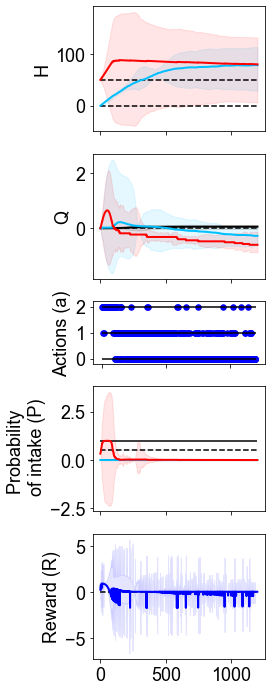

In [12]:
# Water-deficient group (Cell 2)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 18
w_fig = plt.figure(figsize=(4,12))

w_spec = gridspec.GridSpec(ncols=1, nrows=5, height_ratios=[2,2,1,2,2])

w_ax_l = []
w_ax_l.append(w_fig.add_subplot(w_spec[0]))
w_ax_l.append(w_fig.add_subplot(w_spec[1]))
w_ax_l.append(w_fig.add_subplot(w_spec[2]))
w_ax_l.append(w_fig.add_subplot(w_spec[3]))
w_ax_l.append(w_fig.add_subplot(w_spec[4]))


CL = 0.95# Confidencial Level for Figures
Df = N_exp-1# degree of freedom for Figures

w_mean = [] #mean at t
w_STD = []
#SE = []# Standard Error for Figures
w_CI = np.zeros((8, N_i+1, 2)) #confidence intervals at t


for j, h in zip(['H0','H1','Q0','Q1','Q2','P1','P2','R'], list(range(8))):
    for i in range(N_i+1):
        w_mean.append(sum(w_df.loc[w_df['trial']==i][j])/N_exp)
        w_STD.append(st.stdev(w_df.loc[w_df['trial']==i][j]))
        w_CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = w_mean[-1], scale = 2*w_STD[-1])[0]
        w_CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = w_mean[-1], scale = 2*w_STD[-1])[1]
        
         
length_l, length_s = N_i+1, N_i


w_ax_l[0].hlines(50, 0, N_i, linestyle="dashed")
w_ax_l[0].hlines(0, 0, N_i, linestyle="dashed")
w_ax_l[0].plot(w_df['H0'][:length_l], linewidth=2, color='#00BFFF')
w_ax_l[0].plot(w_df['H1'][:length_l], linewidth=2, color='red')
w_ax_l[0].fill_between(w_df.index[:length_l], w_CI[0, :, 0], w_CI[0, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
w_ax_l[0].fill_between(w_df.index[:length_l], w_CI[1, :, 0], w_CI[1, :, 1], color='red', alpha=rd) #confidence interval curves.
w_ax_l[0].set_ylabel('H', fontsize=fs, fontname='Arial')
w_ax_l[0].tick_params(labelbottom=False)


w_ax_l[1].hlines(0, 0, N_i, linestyle="dashed")
w_ax_l[1].plot(w_df['Q0'][:length_l], linewidth=2, color='black')
w_ax_l[1].fill_between(w_df.index[:length_l], w_CI[2, :, 0], w_CI[2, :, 1], color='black', alpha=rd) #confidence interval curves.
w_ax_l[1].plot(w_df['Q1'][:length_l], linewidth=2, color='#00BFFF')
w_ax_l[1].fill_between(w_df.index[:length_l], w_CI[3, :, 0], w_CI[3, :, 1], color='#00BFFF', alpha=rd) #confidence interval curves.
w_ax_l[1].plot(w_df['Q2'][:length_l], linewidth=2, color='red')
w_ax_l[1].fill_between(w_df.index[:length_l], w_CI[4, :, 0], w_CI[4, :, 1], color='red', alpha=rd) #confidence interval curves.
w_ax_l[1].set_ylabel('Q' , fontsize=fs, fontname='Arial')
w_ax_l[1].tick_params(labelbottom=False)


w_ax_l[2].hlines(0, 0, N_i)
w_ax_l[2].hlines(1, 0, N_i)
w_ax_l[2].hlines(2, 0, N_i)
w_ax_l[2].scatter(list(range(length_s)), w_df['A'][:length_s], s=30, c='blue')
w_ax_l[2].set_ylabel('Actions (a)' , fontsize=fs, fontname='Arial')
w_ax_l[2].set_yticks([0,1,2])
w_ax_l[2].tick_params(labelbottom=False)


w_ax_l[3].hlines(0, 0, N_i)
w_ax_l[3].hlines(0.5, 0, N_i,  linestyle="dashed")
w_ax_l[3].hlines(1, 0, N_i)
w_ax_l[3].plot(w_df['P1'][:length_s], linewidth=2, color='#00BFFF')
w_ax_l[3].plot(w_df['P2'][:length_s], linewidth=2, color='red')
w_ax_l[3].fill_between(w_df.index[:length_s], w_CI[5, :, 0][:length_s], w_CI[5, :, 1][:length_s], color='#00BFFF', alpha=rd) #confidence interval curves.
w_ax_l[3].fill_between(w_df.index[:length_s], w_CI[6, :, 0][:length_s], w_CI[6, :, 1][:length_s], color='red', alpha=rd) #confidence interval curves.
w_ax_l[3].set_ylabel('Probability \n of intake (P)' , fontsize=fs, fontname='Arial')
w_ax_l[3].tick_params(labelbottom=False)


w_ax_l[4].hlines(0, 0, N_i, linestyle="dashed")
w_ax_l[4].plot(w_df['R'][:length_s], linewidth=2, color='blue')
w_ax_l[4].fill_between(w_df.index[:length_s], w_CI[7, :, 0][:length_s], w_CI[7, :, 1][:length_s], color='blue', alpha=rd) #confidence interval curves.
w_ax_l[4].set_ylabel('Reward (R)' , fontsize=fs, fontname='Arial')

w_fig.subplots_adjust(left=0.3)
w_fig.savefig("Fig3H.png")



In [13]:
def count_lick(actions_list):
    water_count = 0
    saltwater_count = 0
    for i in actions_list:
        if i == 1:
            water_count+=1
        elif i == 2:
            saltwater_count+=1
    water_count/=N_exp
    saltwater_count/=N_exp
    
    return [water_count, saltwater_count]


In [14]:
c_water_count, c_salt_count = count_lick(a_a)
wna_water_count, wna_salt_count = count_lick(wna_a_a)
w_water_count, w_salt_count = count_lick(w_a_a)
na_water_count, na_salt_count = count_lick(na_a_a)


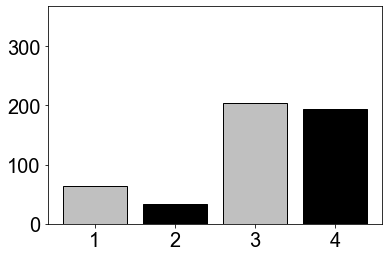

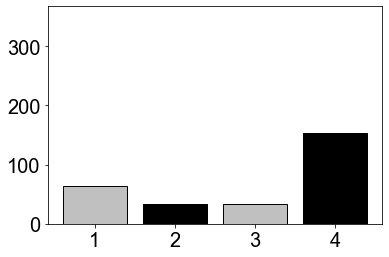

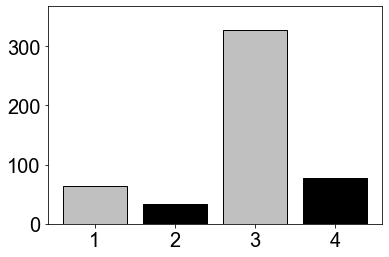

In [15]:
left = np.array([1, 2, 3, 4])
height = [[c_water_count, c_salt_count, wna_water_count, wna_salt_count],
                   [c_water_count, c_salt_count, na_water_count, na_salt_count],
                   [c_water_count, c_salt_count, w_water_count, w_salt_count]]
plt1 = plt.bar(left, height[0])
plt1[0].set_color('#C0C0C0')
plt1[0].set_edgecolor('k')
plt1[1].set_color('k')
plt1[2].set_color('#C0C0C0')
plt1[2].set_edgecolor('k')
plt1[3].set_color('k')
plt.tick_params(labelsize=20)
plt.hlines(350, 1, 4, color='w')
plt.show()

plt2 = plt.bar(left, height[1])
plt2[0].set_color('#C0C0C0')
plt2[0].set_edgecolor('k')
plt2[1].set_color('k')
plt2[2].set_color('#C0C0C0')
plt2[2].set_edgecolor('k')
plt2[3].set_color('k')
plt.tick_params(labelsize=20)
plt.hlines(350, 1, 4, color='w')
plt.show()

plt3 = plt.bar(left, height[2])
plt3[0].set_color('#C0C0C0')
plt3[0].set_edgecolor('k')
plt3[1].set_color('k')
plt3[2].set_color('#C0C0C0')
plt3[2].set_edgecolor('k')
plt3[3].set_color('k')
plt.tick_params(labelsize=20)
plt.hlines(350, 1, 4, color='w')
plt.show()